# 从头开始做 Logistic Regression

本文使用 [Iris Dataset](http://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) 来演示如何进行 logistic regression。

过程**不使用现成**的 data model library，而是按照数学原理，编写程序实现。透过这样的从头开始的实践过程，更好的理解 logistic regression。

## Iris Dataset

先引用使用到的模块:

In [8]:
from sklearn import datasets
import matplotlib as mplib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 打印格式设定
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=5, suppress=True)

为了方便绘图，这里只使用 iris dataset 的两个 features: 

- sepal length : 花萼长度，作为 2D图中的 X 轴, 以 x1 表示
- sepal width : 花萼宽度，作为 2D图中的 Y 轴, 以 x2 表示
- 目标分类是三种不同的鳶尾花卉: 'setosa', 'versicolor', 'virginica', 以 y 表示

| iris setosa | iris versicolor | iris virginica |
|-|-|-|
| <img src="img-iris/iris-setosa.jpg" style="width:150px" /> | <img src="img-iris/iris-versicolor.jpg" style="width:150px" /> | <img src="img-iris/iris-virginica.jpg" style="width:150px" /> |

In [7]:
iris = datasets.load_iris()
s_features = iris.data[:, :2]  # only using first two features.
s_targets  = iris.target.reshape(iris.target.size, 1)
df_iris = pd.DataFrame(data=np.concatenate((s_targets, s_features), axis=1),
                       columns=['y','x1','x2'],
                       dtype=float)
df_iris.describe()

,y,x1,x2
count,150.00,150.00,150.00
mean,1.00,5.84,3.05
std,0.82,0.83,0.43
min,0.00,4.30,2.00
25%,0.00,5.10,2.80
50%,1.00,5.80,3.00
75%,2.00,6.40,3.30
max,2.00,7.90,4.40


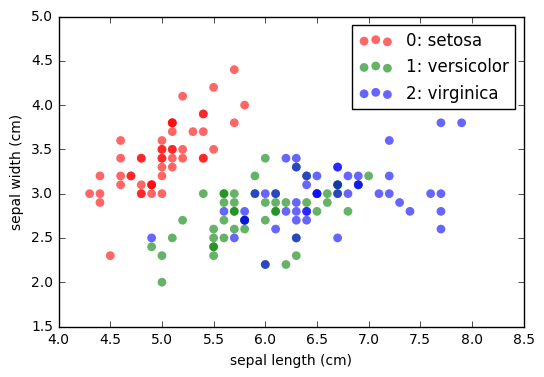

In [3]:
colors_label = {0:'r', 1:'g', 2:'b'}
types = (df_iris.loc[df_iris['y']==0],
         df_iris.loc[df_iris['y']==1],
         df_iris.loc[df_iris['y']==2])

ax = plt.gca()
for t in range(3):
    ax.scatter(types[t]['x1'], 
                types[t]['x2'], 
                c = colors_label[t], 
                s=40, 
                alpha=0.6, 
                edgecolors='none', 
                label='%d: %s' % (t, iris.target_names[t]))

ax.set_xlabel(iris.feature_names[0])
ax.set_ylabel(iris.feature_names[1])
ax.legend()
plt.show();

上图是从 x1, x2 两个 feature 构成的 2D 平面 目标分类 分佈的情况，  
可以看到 0:setosa 是较容易区分出来的；  
而 1:versicolor, 2:verginca 两个种类，在这两个 feature 上会有难以区分的一块区域。

## Algorithm

这里我们要使用 logistic regression 来预测目标为某个种类的 **概率** 有多大。多元分类是使用 OVA (One-Versus-All) 的方法。

logistic regression 是使用一个 theta $ \theta $ 函数，获得一个介于 0~1 之间的几率值。

$$
y = \frac{1}{1+\exp(-x)} = \frac{ e^x }{1 + e^x } = \theta( x ) = 1 - \theta(-x)
$$

算法的目的是最小化 Cross Entropy Error: 

$$ 
E_{in}(w) = \frac{1}{N} \sum_{n=1}^N \ln \Big( 1 + \exp(-y_n w^T x_n) \Big) + \underbrace{\frac{\lambda}{2 N} \sum_{j=1}^{\# \ features} \big( w_j^2 \big)}_{\text{L2 regularizer}} $$

最佳化的过程使用 gradient descent，一步一步求的最小化的梯度

$$
\nabla E_{in}(w_t) = \frac{1}{N} \sum_{n=1}^N \theta \Big( -y_n w_t^T x_n \Big) \big( -y_n x_n \big) + \underbrace{\frac{\lambda}{N} w_j}_{for \ j \ge 1}
$$

先把上面三个算式写成 python functions:

In [11]:
# logistic function : theta
def theta(z):
    return 1. / (1. + np.exp(-z))

# 计算 Cross Entropy Error
def cost_function_reg(w, X, y, lamda):
    m = len(y) * 1.0
    regularization_term = (float(lamda)/2) * w**2
    cost_vector = np.log(1 + np.exp(-y * X.dot(w)))
    ERR = -sum(cost_vector)/m + sum(regularization_term)/m
    return ERR[0]

# 计算目前的梯度值
def gradient(w, X, y, lamda):
    m = len(y) * 1.0
    err_term = theta(-y * X.dot(w)) * (-y * X)
    reg_term = lamda * w / m
    err_augmented = sum(err_term).reshape(X.shape[1], 1) + reg_term
    return err_augmented

接着准备几个 function，在后面 训练 / 预测 / 视觉化 的过程中会用到

In [13]:
# 一步一步进行梯度下降的过程:
def gradient_descent(X, y, lamda, max_loop, err_ce_grad_target, eta, show_progress=False):    
    w = np.ones(X.shape[1]).reshape(X.shape[1],1)
    count_iterations = 0
    for i in range(p_loop):
        count_iterations += 1
        err_grad = gradient(w, X, y, lamda)
        len_e_grad = np.linalg.norm(err_grad)
        eta_fix = eta / len_e_grad
        if len_e_grad <= err_ce_grad_target:
            break
        w = w - eta_fix * err_grad
        w_len = np.linalg.norm(w)
        if show_progress:
            err_ce = cost_function_reg(w, X, y, lamda)
            print('round %d - w_len=%.4f   e_grad_length=%.8f, ein_ce=%.5f' % (i, w_len, len_e_grad, err_ce))
    
    err_ce = cost_function_reg(w, X, y, lamda)    
    return (w, err_ce, count_iterations)

# 利用算出的 w model, 给定 x1, x2, 进行 y 的预测
def predict(w, x1, x2):
    dx0 = np.ones(x1.size)
    dx1 = x1.flatten()
    dx2 = x2.flatten()
    dX = np.concatenate((dx0, dx1, dx2)).reshape(3, x1.size).T
    scores = dX.dot(w).flatten().reshape(x1.shape)
    y = theta(scores)
    return y

# 对每个单一类别进行 training
def fit(X, y, lamda, max_loop, err_ce_grad_target, eta, show_progress=False):
    w, err_ce, loops = gradient_descent(X, y,
                                        lamda=lamda, max_loop=max_loop, 
                                        err_ce_grad_target=err_ce_grad_target, 
                                        eta=eta, show_progress=show_progress)
    print('final result (%d loops): w = %s, ERROR=%.6f' % (loops, w.T[0], err_ce))
    return (w, err_ce)

# 画出 2D Plot
def draw_axe(ax, df, train_for_y_label):
    for i in range(len(df_iris)):
        g_mark = 'D' if (df.loc[i,'usage'] == 'test' and df.loc[i,'g_error'] > 0.) else marks[df.loc[i,'usage']]
        g_alpha = 0.6 if g_mark == 'D' else 0.5
        g_size = 100 if g_mark == 'D' else 60
        g_y = df[train_for_y_label][i]
        ax.scatter(df.loc[i,'x1'],
                   df.loc[i,'x2'],
                   marker=g_mark,
                   c = colors[g_y], s=g_size, alpha=g_alpha)

以上算法的内容框架已经具备，在开始训练前，对资料进行预处理:

In [14]:
# 将多元分类问题，拆解成几个二元分类问题
target_classes = [0,1,2]
for i in range(3):
    df_iris.loc[df_iris.loc[:,'y'] != i, 'y_is_%d' % i] = -1
    df_iris.loc[df_iris.loc[:,'y'] == i, 'y_is_%d' % i] = 1

# 加入常数项
df_iris['x0'] = np.ones(df_iris.shape[0])

# 用 30% 的资料作为测试资料
test_size = 0.3
df_iris['usage'] = np.where(np.random.rand(len(df_iris)) < test_size, 'test', 'train')

接着进行训练，预测，视觉化

final result (10000 loops): w = [ 46.13966 -19.48376  18.888  ], ERROR=-0.001755
validation error: 0.0000
final result (10000 loops): w = [ 7.81651  0.11808 -3.21775], ERROR=-0.517010
validation error: 0.2800
final result (10000 loops): w = [-13.233     2.47044  -0.90901], ERROR=-0.394292
validation error: 0.2200


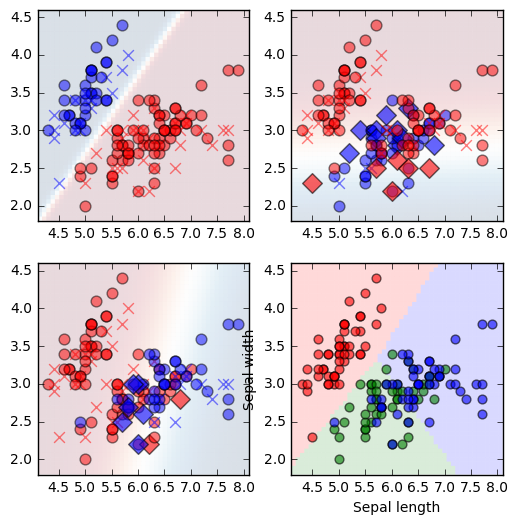

In [15]:
p_lamda = 0.0001
p_limit = 1e-5
p_loop = 10000
p_eta = 0.1

colors = {1:'b',-1:'r'}
marks = {'train':'o', 'test':'x'}

g_margin = .2
x1_lim = (df_iris.x1.min() -g_margin, df_iris.x1.max() + g_margin)
x2_lim = (df_iris.x2.min() -g_margin, df_iris.x2.max() + g_margin)
gx1 = np.linspace(x1_lim[0], x1_lim[1], 50)
gx2 = np.linspace(x2_lim[0], x2_lim[1], 50)
gvx1, gvx2 = np.meshgrid(gx1, gx2)


def train_one_class_and_valid(train_for_y_label, df, lamda, max_loop, err_ce_grad_target, eta, show_progress=False):
    df_train = df.loc[np.where(df['usage'] == 'train', True, False),['x0', 'x1','x2',train_for_y_label]]
    X_train = df.loc[:,['x0', 'x1','x2']].as_matrix()
    y_train = df.loc[:,train_for_y_label].as_matrix().reshape(len(df), 1)
    w, err_ce = fit(X_train, y_train, lamda=p_lamda, max_loop=p_loop, 
                            err_ce_grad_target=p_limit, eta=p_eta)
    return (df, w, err_ce)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6,6))
axes = axes.reshape(axes.size,)

gvys = []
for i_class in target_classes:
    train_for_y_label = 'y_is_%d' % i_class
    df = df_iris.copy()
    df, w, err_ce = train_one_class_and_valid(train_for_y_label, df, lamda=p_lamda, max_loop=p_loop,err_ce_grad_target=p_limit, eta=p_eta)
    df['g_prob'] = predict(w, df.x1.as_matrix(), df.x2.as_matrix())
    df['g_predict'] = np.where(df['g_prob'] > 0.5, 1., -1.)
    df['g_error'] = np.where(df['g_predict'] == df[train_for_y_label], 0., 1.)
    print('validation error: %.4f' % np.average(df.g_error))
    ax = axes[i_class]
    gvy = predict(w, gvx1, gvx2)
    gvys.append(gvy)
    ax.set_xlim(x1_lim)
    ax.set_ylim(x2_lim)
    ax.pcolormesh(gvx1, gvx2, gvy, cmap='RdBu', alpha=0.15, linewidth=0, antialiased=True)
    draw_axe(ax, df, train_for_y_label)

iv0 = gvys[0].flatten()
iv1 = gvys[1].flatten()
iv2 = gvys[2].flatten()

ivr = np.ones(gvys[0].shape) * -1.
ivr = ivr.flatten()
for i,iv in enumerate(ivr):
    if iv0[i] >= iv1[i] and iv0[i] >= iv2[i]:
        ivr[i] = 0.
    elif iv1[i] >= iv0[i] and iv1[i] >= iv2[i]:
        ivr[i] = 1.
    else:
        ivr[i] = 2.
    
ivr = ivr.reshape(gvys[0].shape)
ax = axes[3]
ax.set_xlim(x1_lim)
ax.set_ylim(x2_lim)
cMap = mplib.colors.ListedColormap(['r','g','b'])
ax.pcolormesh(gvx1, gvx2, ivr, cmap=cMap, alpha=0.15, linewidth=0, antialiased=True)

colors2 = {0:'r', 1:'g', 2:'b'}
for i in range(len(df_iris)):
    g_y = df['y'][i]
    ax.scatter(df.loc[i,'x1'],
                   df.loc[i,'x2'],
                   c = colors2[g_y], s=40, alpha=0.6)

ax.set_xlabel('Sepal length')
ax.set_ylabel('Sepal width')
plt.show()

从上图中，前三个图是 OVA 二元分类器 的状况；  

最后第四个图，是综合了三个二元分类器，使用几率最高值来预测结果。